BAYESIAN NEURAL NETWORK PREDICT PRICE DOG-COIN

In [2]:
!pip install blitz
!pip install blitz-bayesian-pytorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for blitz: filename=blitz-0.3.3-py3-none-any.whl size=7249 sha256=cfe564efc6a916c99fb0068a1e710d9e97478bfd525a172c029fb0dbe2ac3bd1
  Stored in directory: /root/.cache/pip/wheels/2c/64/41/ddc70b2e23e810f1f7e2f9c34ed06bde65b1a45ce4fe5acb27
Successfully built blitz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.2 MB/s eta 0:00:00


IMPORT PAKAGES

In [3]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#from blitz.modules.base_bayesian_module import BayesianModule, BayesianRNN, BayesianLSTM
from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

import yfinance as yf

plt.rcParams.update({'figure.figsize':(13,10)})
plt.rcParams.update({'font.size':20})

Nhập mã chứng khoán 

In [23]:
ticker = "DOGE-USD" 

Trích xuất thông tin giá từ Yahoo Finance

In [50]:
ticker_y = yf.Ticker(ticker)
df = ticker_y.history(period="7y")

In [51]:
df.reset_index(inplace=True)

In [52]:
series=df.Close

Definitions - Định nghĩa

In [53]:
window_size = 21
def create_timestamps_ds(series, 
                         timestep_size=window_size):
    time_stamps = []
    labels = []
    aux_deque = deque(maxlen=timestep_size)
    
    #starting the timestep deque
    for i in range(timestep_size):
        aux_deque.append(0)
    
    #feed the timestamps list
    for i in range(len(series)-1):
        aux_deque.append(series[i])
        time_stamps.append(list(aux_deque))
    
    #feed the labels lsit
    for i in range(len(series)-1):
        labels.append(series[i + 1])
    
    assert len(time_stamps) == len(labels), "Something went wrong"
    
    #torch-tensoring it
    features = torch.tensor(time_stamps[timestep_size:]).float()
    labels = torch.tensor(labels[timestep_size:]).float()
    
    return features, labels

In [54]:
@variational_estimator
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.lstm_1 = BayesianLSTM(1, 10, prior_sigma_1=1, prior_pi=1, posterior_rho_init=-3.0)
        self.linear = nn.Linear(10, 1)
            
    def forward(self, x):
        x_, _ = self.lstm_1(x)
        
        #gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear(x_)
        return x_

In [55]:
def pred_stock_future(X_test,
                                           future_length,
                                           sample_nbr=10):
    
    #tạo tiến toàn cục
    global window_size
    global X_train
    global Xs
    global scaler
    
    #tạo các biến phụ trợ để dự đoán trong tương lai
    preds_test = []
    test_begin = X_test[0:1, :, :]
    test_deque = deque(test_begin[0,:,0].tolist(), maxlen=window_size)

    idx_pred = np.arange(len(X_train), len(Xs))
    
    #dự đoán và add vao danh sách
    for i in range(len(X_test)):
        #print(i)
        as_net_input = torch.tensor(test_deque).unsqueeze(0).unsqueeze(2)
        pred = [net(as_net_input).cpu().item() for i in range(sample_nbr)]
        
        
        test_deque.append(torch.tensor(pred).mean().cpu().item())
        preds_test.append(pred)
        
        if i % future_length == 0:
            #đầu vào trở thành index của X_test
            test_begin = X_test[i:i+1, :, :]
            test_deque = deque(test_begin[0,:,0].tolist(), maxlen=window_size)

    #preds_test = np.array(preds_test).reshape(-1, 1)
    #preds_test_unscaled = scaler.inverse_transform(preds_test)
    
    return idx_pred, preds_test

In [56]:
def get_confidence_intervals(preds_test, ci_multiplier):
    global scaler
    
    preds_test = torch.tensor(preds_test)
    
    pred_mean = preds_test.mean(1)
    pred_std = preds_test.std(1).detach().cpu().numpy()

    pred_std = torch.tensor((pred_std))
    #print(pred_std)
    
    upper_bound = pred_mean + (pred_std * ci_multiplier)
    lower_bound = pred_mean - (pred_std * ci_multiplier)
    #gather unscaled confidence intervals

    pred_mean_final = pred_mean.unsqueeze(1).detach().cpu().numpy()
    pred_mean_unscaled = scaler.inverse_transform(pred_mean_final)

    upper_bound_unscaled = upper_bound.unsqueeze(1).detach().cpu().numpy()
    upper_bound_unscaled = scaler.inverse_transform(upper_bound_unscaled)
    
    lower_bound_unscaled = lower_bound.unsqueeze(1).detach().cpu().numpy()
    lower_bound_unscaled = scaler.inverse_transform(lower_bound_unscaled)
    
    return pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled

In [57]:
#Create Window Size after which the prediction will start
window_size = 21

#scaling and selecting data
close_prices = df['Close']
scaler = StandardScaler()

close_prices_arr = np.array(close_prices).reshape(-1, 1)
close_prices = scaler.fit_transform(close_prices_arr)

close_prices_unscaled = df['Close']

In [58]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [68]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Train the linear regression model
model = BayesianLSTM()
model.fit(x_train, y_train)

TypeError: ignored

In [60]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(x_test)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(x_val)

In [61]:
# Xs, ys = create_timestamps_ds(close_prices)
# X_train, X_test, y_train, y_test = train_test_split(Xs,
#                                                     ys,
#                                                     test_size=.25,
#                                                     random_state=42,
#                                                     shuffle=False)



# ds = torch.utils.data.TensorDataset(X_train, y_train)
# dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

# net = NN()

# criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001)

In [41]:
# ds = torch.utils.data.TensorDataset(x_train, y_train)
# dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

# net = NN()

# criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001)

TypeError: ignored

In [39]:
# iteration = 0
# for epoch in range(10):
#     for i, (datapoints, labels) in enumerate(dataloader_train):
#         optimizer.zero_grad()
        
#         loss = net.sample_elbo(inputs=datapoints,
#                                labels=labels,
#                                criterion=criterion,
#                                sample_nbr=3,
#                                complexity_cost_weight=1/X_train.shape[0])
#         loss.backward()
#         optimizer.step()
        
#         iteration += 1
#         if iteration%250==0:
#             preds_test = net(X_test)[:,0].unsqueeze(1)
#             loss_test = criterion(preds_test, y_test)
#             print("Iteration: {} Val-loss: {:.4f}".format(str(iteration), loss_test))

NameError: ignored

In [62]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[0.21906008 0.21919475 0.21932941 0.21946408 0.21959874 0.21973341
 0.21986807 0.22000274 0.2201374  0.22027207 0.22040674 0.2205414
 0.22067607 0.22081073 0.2209454  0.22108006 0.22121473 0.22134939
 0.22148406 0.22161873 0.22175339 0.22188806 0.22202272 0.22215739
 0.22229205 0.22242672 0.22256138 0.22269605 0.22283072 0.22296538]


In [63]:
#pred_unscaled
original = close_prices_unscaled[1:][window_size:]

In [64]:
# df_pred = pd.DataFrame(original)
# df_pred["Date"] = df.Date
# df["Date"] = pd.to_datetime(df_pred["Date"])
# df_pred = df_pred.reset_index()
# #df_pred = df_pred.set_index('Date')

In [45]:
future_length=30 #7
sample_nbr=4
ci_multiplier=5
idx_pred, preds_test = pred_stock_future(X_test, future_length, sample_nbr)
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(preds_test,
                                                                                          ci_multiplier)

NameError: ignored

In [46]:
c=len(upper_bound_unscaled)

NameError: ignored

Calculate the proportion of predictions in the confidence interval

In [47]:
y = np.array(df.Close[-c:]).reshape(-1, 1)
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
total = (under_upper == over_lower)
price_acc = np.mean(total)
print("{} of test price is in our confidence interval".format(round(price_acc,2)))

NameError: ignored

In [1]:
plt.title(ticker + " Price Over Time", color="black")

plt.plot(df_pred.index,
         df_pred.Close,
         color='black',
         label="Real")

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, then consult".format(future_length),
         color="red")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.5)

plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc="upper left",prop={'size': 12})

NameError: ignored

ValueError: ignored

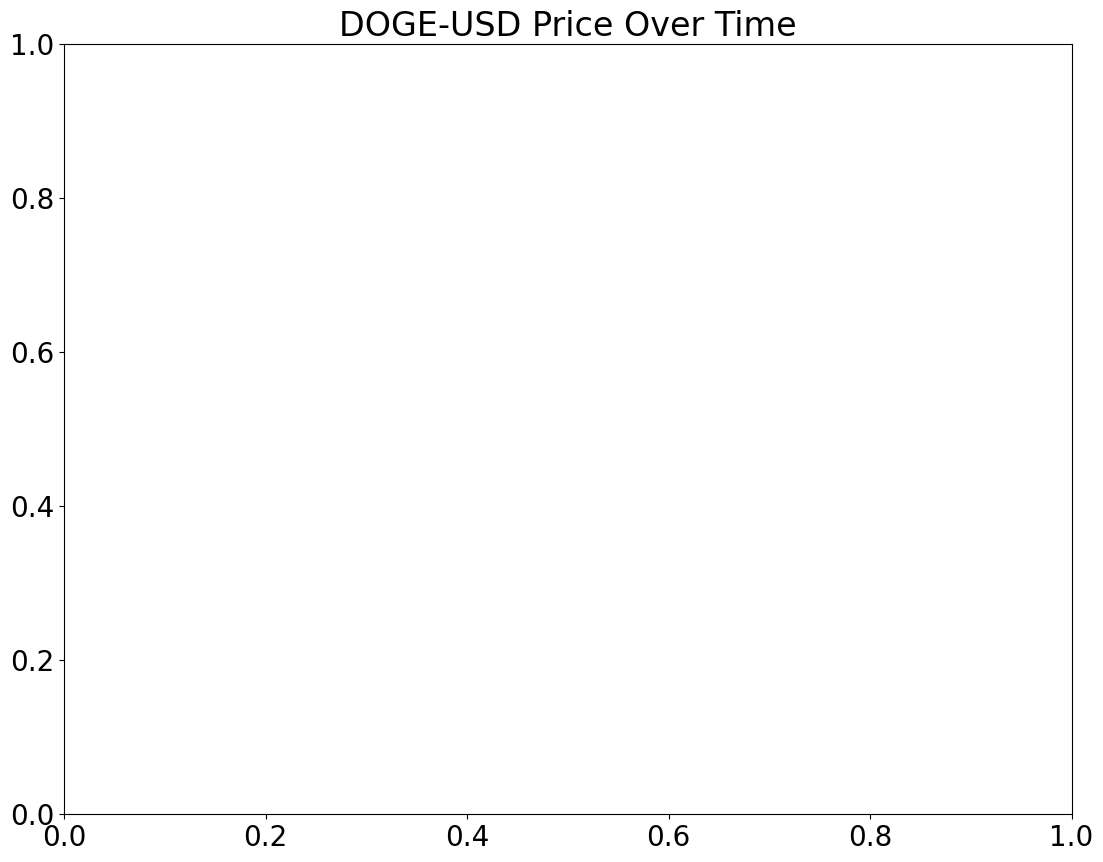

In [ ]:
plt.title(ticker + " Price Over Time", color="black")


plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.75)

plt.plot(idx_pred,
         df_pred.Close[-len(pred_mean_unscaled):],
         label="Real",
         alpha=1,
         color='black',
         linewidth=0.5)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, then consult".format(future_length),
         color="red",
         alpha=0.5)

plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc="upper left",prop={'size': 12})

Analysis on Detrend Price
In general prices of stocks tend to follow an upwards trend. Neural Networks do not predict upwards trending stocks very well. This is because the model will not predict a higher price than what is seen in the training data. Therefor to get around this we can detrend the data and analyze the deviations from that trend.

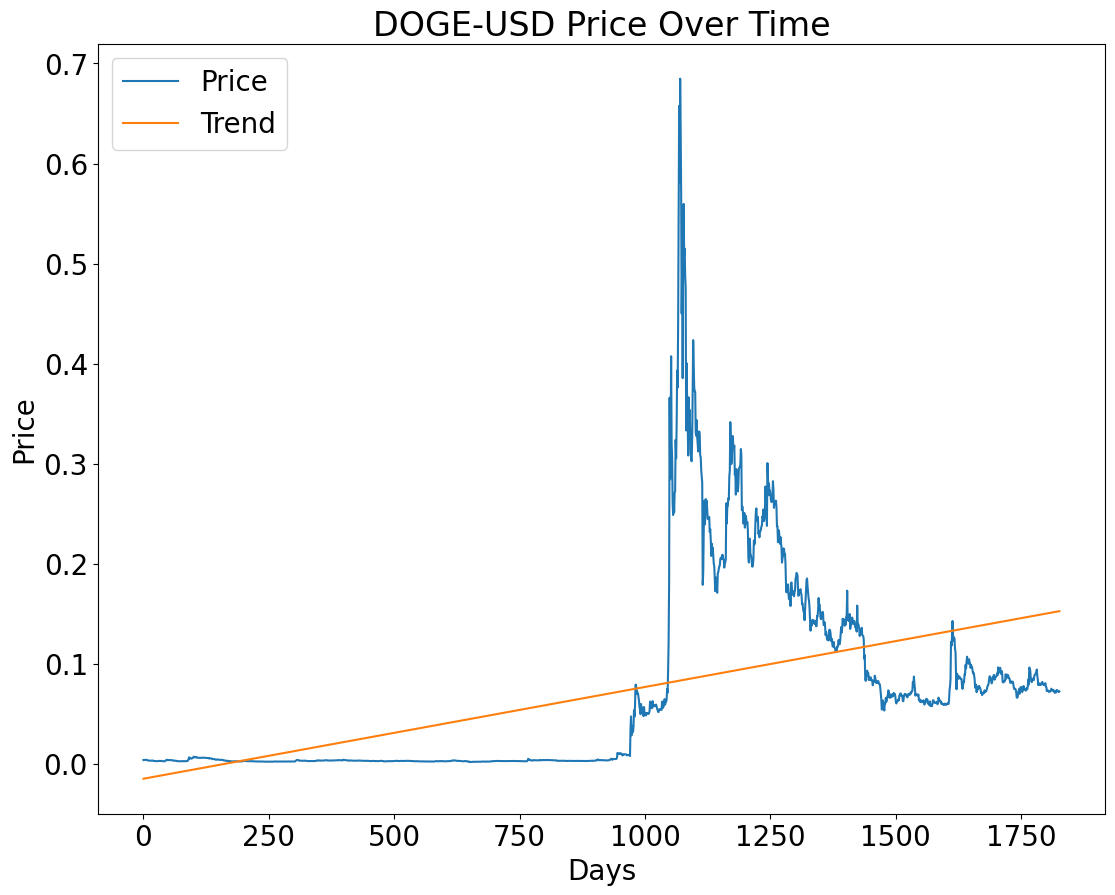

In [ ]:
X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series.values

## Conduct a linear regression on the price.
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)

## Detrend the data by subtracting the price form the linear regression
detrended = [y[i]-trend[i] for i in range(0, len(series))]

## Plot trend and price over time
plt.plot(y, label ="Price")
plt.plot(trend, label ="Trend")
plt.legend(loc="upper left")
plt.title(ticker + " Price Over Time", color="black")
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

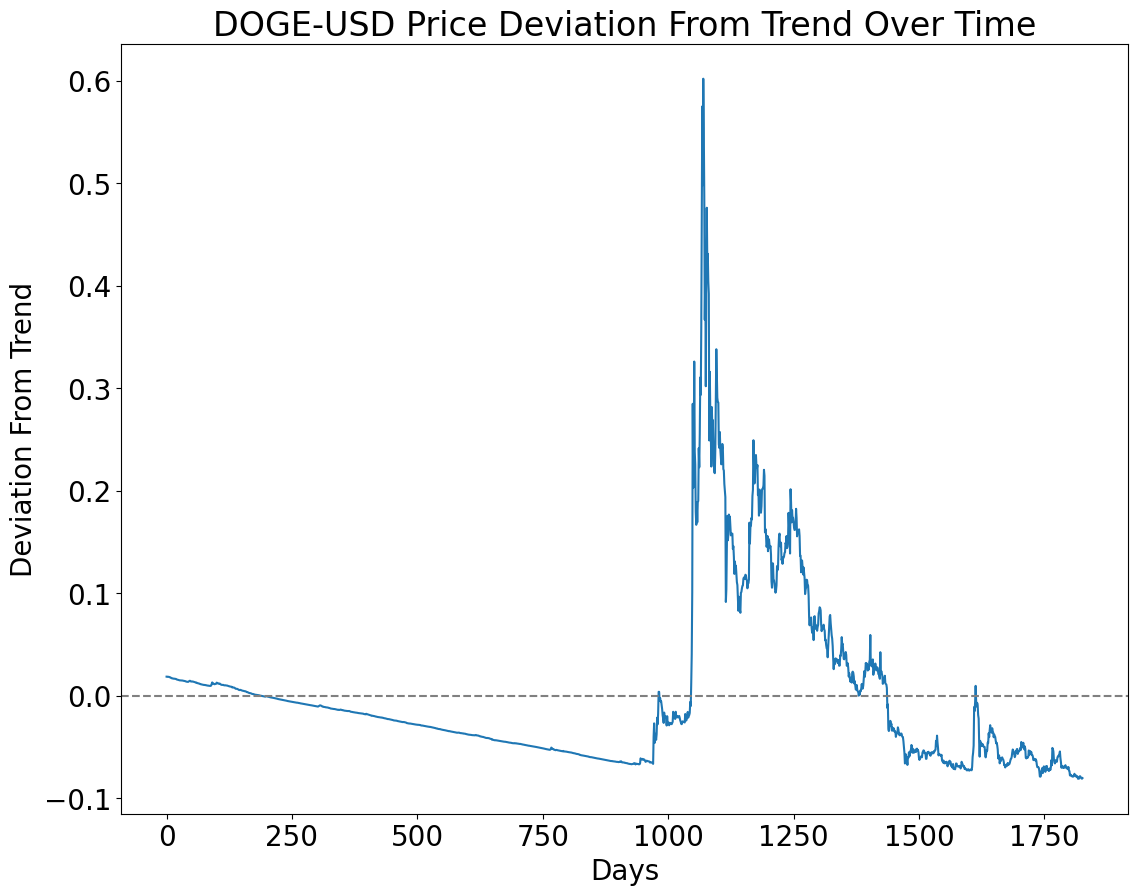

In [ ]:
plt.title(ticker + " Price Deviation From Trend Over Time", color="black")
plt.xlabel('Days')
plt.ylabel('Deviation From Trend')
plt.plot(detrended)
plt.axhline(y=0, color='grey', linestyle='--')
plt.show()

In [ ]:
df['Close']=detrended

Conduct Bayesian Neural Networks with LSTM Architecture

In [ ]:
#Create Window Size after which the prediction will start
window_size = 21

#scaling and selecting data
close_prices = df['Close']
scaler = StandardScaler()

close_prices_arr = np.array(close_prices).reshape(-1, 1)
close_prices = scaler.fit_transform(close_prices_arr)

close_prices_unscaled = df['Close']

In [ ]:
Xs, ys = create_timestamps_ds(close_prices)
X_train, X_test, y_train, y_test = train_test_split(Xs,
                                                    ys,
                                                    test_size=.25,
                                                    random_state=42,
                                                    shuffle=False)



ds = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

net = NN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
len(ys)

1805

In [ ]:
len(Xs)

1805

In [ ]:
iteration = 0
for epoch in range(10):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = net.sample_elbo(inputs=datapoints,
                               labels=labels,
                               criterion=criterion,
                               sample_nbr=3,
                               complexity_cost_weight=1/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%250==0:
            preds_test = net(X_test)[:,0].unsqueeze(1)
            loss_test = criterion(preds_test, y_test)
            print("Iteration: {} Val-loss: {:.4f}".format(str(iteration), loss_test))

Iteration: 250 Val-loss: 0.1498
Iteration: 500 Val-loss: 0.0991
Iteration: 750 Val-loss: 0.0175
Iteration: 1000 Val-loss: 0.0199
Iteration: 1250 Val-loss: 0.0305
Iteration: 1500 Val-loss: 0.0073


In [ ]:
#pred_unscaled
original = close_prices_unscaled[1:][window_size:]

In [ ]:
df_pred = pd.DataFrame(original)
df_pred["Date"] = df.Date
df["Date"] = pd.to_datetime(df_pred["Date"])
df_pred = df_pred.reset_index()
#df_pred = df_pred.set_index('Date')

In [ ]:
future_length=30
sample_nbr=4
ci_multiplier=5
idx_pred, preds_test = pred_stock_future(X_test, future_length, sample_nbr)
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(preds_test,
                                                                                          ci_multiplier)

In [ ]:
c=len(upper_bound_unscaled)

In [ ]:
y = np.array(df.Close[-c:]).reshape(-1, 1)
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
total = (under_upper == over_lower)
detrended_acc = np.mean(total)
print("{} of test detrended price is in our confidence interval".format(round(detrended_acc,2)))

0.54 of test detrended price is in our confidence interval


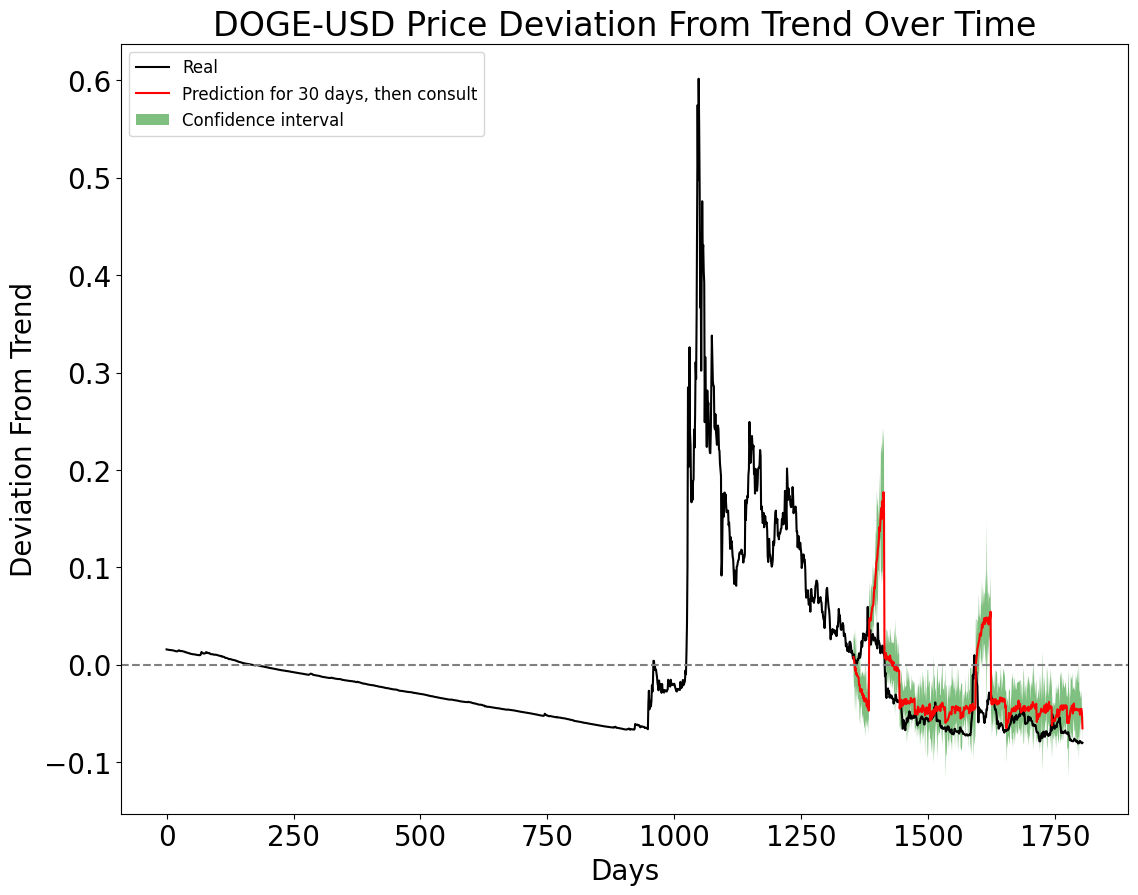

In [ ]:
plt.title(ticker + " Price Deviation From Trend Over Time", color="black")

plt.plot(df_pred.index,
         df_pred.Close,
         color='black',
         label="Real")

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, then consult".format(future_length),
         color="red")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.5)

plt.xlabel('Days')
plt.ylabel('Deviation From Trend')
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc="upper left",prop={'size': 12})

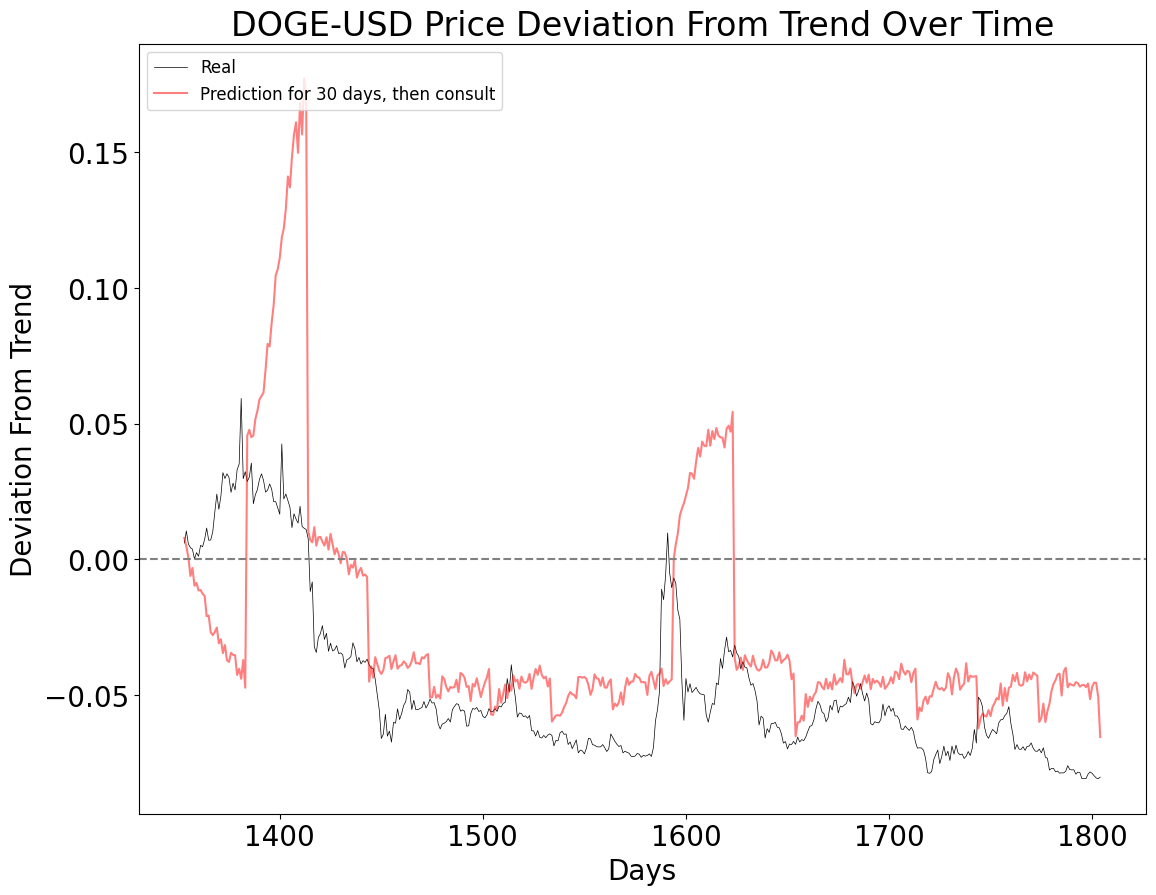

In [ ]:
plt.title(ticker + " Price Deviation From Trend Over Time", color="black")


# plt.fill_between(x=idx_pred,
#                  y1=upper_bound_unscaled[:,0],
#                  y2=lower_bound_unscaled[:,0],
#                  facecolor='green',
#                  label="Confidence interval",
#                  alpha=0.75)

plt.plot(idx_pred,
         df_pred.Close[-len(pred_mean_unscaled):],
         label="Real",
         alpha=1,
         color='black',
         linewidth=0.5)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, then consult".format(future_length),
         color="red",
         alpha=0.5)

plt.xlabel('Days')
plt.ylabel('Deviation From Trend')
plt.legend(loc="upper left",prop={'size': 12})
plt.axhline(y=0, color='grey', linestyle='--')

In [ ]:
print("{} of test price is in our confidence interval for normal price".format(round(price_acc,2)))
print("{} of test price is in our confidence interval for detrended price".format(round(detrended_acc,2)))
print("Detrended has {} more of test price in our confidence interval compared to normal price".format(round(detrended_acc-price_acc,2)))

0.92 of test price is in our confidence interval for normal price
0.58 of test price is in our confidence interval for detrended price
Detrended has -0.35 more of test price in our confidence interval compared to normal price
